In [711]:
import scipy.stats as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import tree
from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble

In [516]:
dfu=pd.read_csv("maliuk_unigram_features.csv")

featue 1 p-value = 0.00000000
featue 2 p-value = 0.00012838


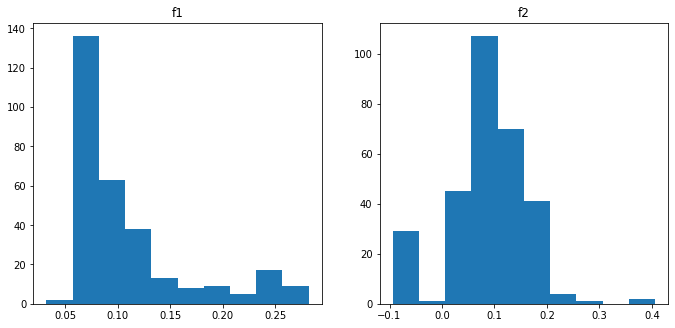

In [517]:
plt.figure(figsize=(30, 30))
c=1
for i in range(2):
    plt.subplot(5, 5, c)
    plt.title("f{}".format(i+1))
    c+=1
    f = np.array(dfu["f{}".format(i+1)])
    plt.hist(f)
    print("featue {} p-value = {:.8f}".format(i+1, sc.kstest(f, 'norm', args=(np.mean(f), np.std(f, ddof=1)))[1]))
plt.show()

p-value надто маленьке щоб вважати, що будь-який з цих розподілів нормальний. Хоча друга фіча(час між натисками клавіш) більш схожа на нормальний розподіл і при деяких розумних значеннях $\alpha$ можна прийняти нульову гіпотезу (про нормальність розподілу). 
<br>Такі ж самі результати отримоємо, якщо взіти датасет датасет іншої людини:

In [518]:
dfu=pd.read_csv("ann-marie_unigram_features.csv")

featue 1 p-value = 0.00000000
featue 2 p-value = 0.00657310


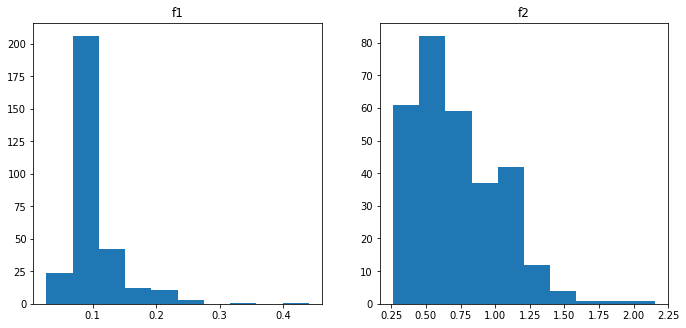

In [519]:
plt.figure(figsize=(30, 30))
c=1
for i in range(2):
    plt.subplot(5, 5, c)
    plt.title("f{}".format(i+1))
    c+=1
    f = np.array(dfu["f{}".format(i+1)])
    plt.hist(f)
    print("featue {} p-value = {:.8f}".format(i+1, sc.kstest(f, 'norm', args=(np.mean(f), np.std(f, ddof=1)))[1]))
plt.show()

In [568]:
def normalize_std(X):
    res=np.mean(X, axis=0)
    stdd=np.std(X, axis=0)
    return (X-res)/stdd

In [826]:
def test(model,x_test,y_test):
    model.fit(x_train,y_train)
    y_proba=model.predict_proba(x_test)
    y_pred=model.predict(x_test)
    
    res={}
#     loss=np.mean(np.log(y_proba[:,0]) * (y_test-1) - np.log(y_proba[:,1])*y_test)
    loss=metrics.log_loss(y_test,y_proba)
    res["log-loss"] = loss
    
    tp = np.sum(y_pred & y_test)
    tn = np.sum(np.logical_not(y_pred) & np.logical_not(y_test))
    fp = np.sum(y_pred & np.logical_not(y_test))
    fn = np.sum(np.logical_not(y_pred) & y_test)
#     print(np.array([[tp,fp],[fn,tn]]))
    FAR = fp/np.sum(y_test==0)
    FRR = fn/np.sum(y_test==1)
    res["FAR"] = FAR
    res["FRR"] = FRR
    
    precision=tp/(fp+tp)
    recall=tp/(tp+fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    res["F-score"] = F1
    
    return res

In [827]:
def performance(x_false,x_true, rep=1):
#     normalizing data
    data=np.concatenate((x_false,x_true),axis=0)
    data=normalize_std(data)
    x_false=data[:x_false.shape[0]]
    x_true=data[x_false.shape[0]:]
#     choicing random records
    sample = np.random.choice(np.arange(x_false.shape[0]),x_true.shape[0],replace = False)
    x_false = np.concatenate((np.ones((x_true.shape[0],1)),x_false[sample]),axis=1)
    x_true = np.concatenate((np.ones((x_true.shape[0],1)),x_true),axis=1)
#     dividing dataset in training and test datasets
    t=np.arange(x_true.shape[0])
    np.random.shuffle(t)
    true_train=x_true[t[:x_true.shape[0]//2]]
    true_test=x_true[t[x_true.shape[0]//2:]]
    np.random.shuffle(t)
    false_train=x_false[t[:x_true.shape[0]//2]]
    false_test=x_false[t[x_true.shape[0]//2:]]
    
    y_train=np.concatenate((np.ones((x_true.shape[0]//2),dtype="int32"),np.zeros((x_true.shape[0]//2),dtype="int32")),axis=0)
    x_train=np.concatenate((true_train,false_train),axis=0)
    y_test=np.concatenate((np.ones((x_true.shape[0]-x_true.shape[0]//2),dtype="int32"),np.zeros((x_true.shape[0]-x_true.shape[0]//2),dtype="int32")))
    x_test=np.concatenate((true_test,false_test),axis=0)
    
#     training logistic regression model

    perf=pd.DataFrame({"model":np.array([],dtype=str),"log-loss":np.array([],dtype=float),"FAR":np.array([],dtype=float),"FRR":np.array([],dtype=float),
                       "F-score": np.array([],dtype=float)})
    
    dic={"model": "log"}
    reg = linear_model.LogisticRegression(solver="lbfgs")
    t = test(reg, x_test,y_test)
    for i in test(reg, x_test,y_test).keys():
        dic[i]=t[i]
    perf=perf.append(dic,ignore_index=True)
    
#     training svm model

    dic={"model": "svm"}
    vm = svm.SVC(gamma='auto',probability=True)
    t = test(vm, x_test,y_test)
    for i in test(reg, x_test,y_test).keys():
        dic[i]=t[i]
    perf=perf.append(dic,ignore_index=True)
    
#     training fandom forest model
    
    dic={"model": "forest"}
    begi = ensemble.RandomForestClassifier(n_estimators=100)
    t = test(begi, x_test,y_test)
    for i in test(reg, x_test,y_test).keys():
        dic[i]=t[i]
    perf=perf.append(dic,ignore_index=True)
    return perf

In [828]:
valerii_unigram = pd.read_csv("features/valerii_unigram_features.csv")
valerii_bigram = pd.read_csv("features/valerii_bigram_features.csv")
valerii_trigram = pd.read_csv("features/valerii_trigram_features.csv")

ann_marie_unigram = pd.read_csv("features/ann-marie_unigram_features.csv")
ann_marie_bigram = pd.read_csv("features/ann-marie_bigram_features.csv")
ann_marie_trigram = pd.read_csv("features/ann-marie_trigram_features.csv")

bohdan_unigram = pd.read_csv("features/bohdan_unigram_features.csv")
bohdan_bigram = pd.read_csv("features/bohdan_bigram_features.csv")
bohdan_trigram = pd.read_csv("features/bohdan_trigram_features.csv")

serhii_unigram = pd.read_csv("features/serhii_unigram_features.csv")
serhii_bigram = pd.read_csv("features/serhii_bigram_features.csv")
serhii_trigram = pd.read_csv("features/serhii_trigram_features.csv")

unigram

In [829]:
rep=10   #mean losses over rep repeats

In [830]:
x_false=np.concatenate((ann_marie_unigram,bohdan_unigram,serhii_unigram),axis=0)[:,-2:].astype(np.float64)    #not ovner
x_true=np.array(valerii_unigram.iloc[:,-2:],dtype=np.float64)
unigrams=[]
for i in range(rep):
    unigrams.append(performance(x_false,x_true))
unigram=unigrams[0]
for i in unigrams[1:]:
    unigram.iloc[:,1:]+=i.iloc[:,1:]
unigram.iloc[:,1:]/=rep
unigram

,model,log-loss,FAR,FRR,F-score
0,log,0.476693,0.356667,0.108667,0.793208
1,svm,0.460295,0.342000,0.067333,0.820210
2,forest,0.327455,0.118667,0.128000,0.876081


bigram

In [831]:
x_false=np.concatenate((ann_marie_bigram,bohdan_bigram,serhii_bigram),axis=0)[:,-2:].astype(np.float64)    #not ovner
x_true=np.array(valerii_bigram.iloc[:,-2:],dtype=np.float64)
bigrams=[]
for i in range(rep):
    bigrams.append(performance(x_false,x_true))
bigram=bigrams[0]
for i in bigrams[1:]:
    bigram.iloc[:,1:]+=i.iloc[:,1:]
bigram.iloc[:,1:]/=rep
bigram

,model,log-loss,FAR,FRR,F-score
0,log,0.467819,0.348889,0.091111,0.805116
1,svm,0.443318,0.337778,0.057778,0.826559
2,forest,0.283847,0.102963,0.104444,0.896174


trigram

In [833]:
x_false=np.concatenate((ann_marie_trigram,bohdan_trigram,serhii_trigram),axis=0)[:,-2:].astype(np.float64)    #not ovner
x_true=np.array(valerii_trigram.iloc[:,-2:],dtype=np.float64)
trigrams=[]
for i in range(rep):
    trigrams.append(performance(x_false,x_true))
trigram=trigrams[0]
for i in trigrams[1:]:
    trigram.iloc[:,1:]+=i.iloc[:,1:]
trigram.iloc[:,1:]/=rep
trigram

,model,log-loss,FAR,FRR,F-score
0,log,0.462681,0.344167,0.108333,0.797820
1,svm,0.433705,0.349167,0.065000,0.818891
2,forest,0.172964,0.099167,0.023333,0.941056
